Loading local Chicago Crime Data from ../data/chicago_crime_data.csv
Columns in CSV: ['Date', 'Primary Type', 'Latitude', 'Longitude']
Sampled 20000 rows from Chicago data
Loaded Chicago data
Shape after dropping missing coordinates: (19776, 4)
Head after dropping NaN:
                            Date                      Primary Type   Latitude  \
5967492  07/24/2015 07:30:00 AM                             THEFT  41.768406   
3608884  08/17/2008 10:28:00 PM  INTERFERENCE WITH PUBLIC OFFICER  41.762436   
3607847  10/27/2008 04:45:00 PM                DECEPTIVE PRACTICE  41.828236   
3990228  03/27/2009 02:00:00 PM                DECEPTIVE PRACTICE  41.881622   
3411041  12/23/2007 01:30:00 PM                         NARCOTICS  41.881046   

         Longitude  
5967492 -87.676834  
3608884 -87.641479  
3607847 -87.638733  
3990228 -87.629395  
3411041 -87.699348  
Shape after filtering violent crimes: (5765, 4)
Crime types: Primary Type
BATTERY     3650
ASSAULT     1332
ROBBERY      7

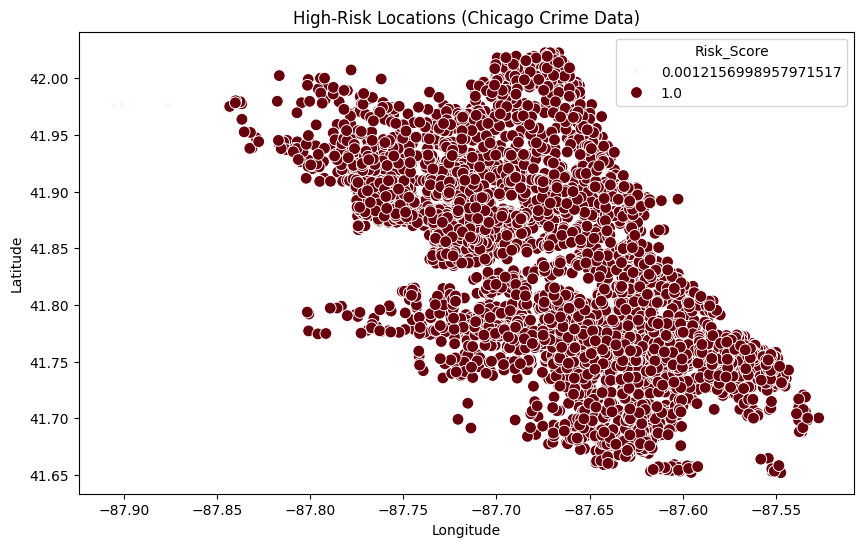

Assigned to cluster 0 with risk score 1.00
Risk Score for (41.8865, -87.622): 1.00
Assigned to cluster 0 with risk score 1.00
Risk Score for (41.8781, -87.6298): 1.00
Assigned to cluster 0 with risk score 1.00
Risk Score for (41.918, -87.636): 1.00


['scaler.pkl']

In [1]:
# Jupyter Notebook: Risky Location Model for Personal Security Solution

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Note: Fixed issues:
# 1. Clustering bug (DBSCAN() label) by using dbscan.fit_predict.
# 2. Improved predict_risk_score to assign clusters correctly.
# 3. Added debugging for clustering and predictions.
# Using local Chicago dataset at '../data/chicago_crime_data.csv'.
# Sampling 10,000 rows to avoid overfitting.
# Overfitting in DBSCAN: Too many/small clusters if eps too small.
# Tune eps (e.g., 0.5-2.0) and min_samples (e.g., 5-20).
# Tunisia data (Ministry 2014-2015, Numbeo) lacks geolocation.
# Check https://knoema.com/atlas/Tunisia/datasets or https://opendata.interieur.gov.tn/

# Step 1: Load and preprocess crime data
knoema_file = '../data/tunisia_crime_data.csv'
ministry_file = '../data/tunisia_ministry_crime_data.csv'
chicago_file = '../data/chicago_crime_data.csv'

# Number of rows to sample
sample_size = 20000  # Increase to 20000 if too few clusters

# Optimize data types
dtypes = {
    'Latitude': 'float32',
    'Longitude': 'float32',
    'Primary Type': 'category',
    'Date': 'object'
}

try:
    if os.path.exists(knoema_file):
        df = pd.read_csv(knoema_file, dtype=dtypes)
        print("Loaded Knoema Tunisia Crime Data")
    elif os.path.exists(ministry_file):
        df = pd.read_csv(ministry_file, dtype=dtypes)
        print("Loaded Tunisian Ministry of Interior Crime Data")
    elif os.path.exists(chicago_file):
        print(f"Loading local Chicago Crime Data from {chicago_file}")
        chunks = pd.read_csv(chicago_file, usecols=['Latitude', 'Longitude', 'Primary Type', 'Date'],
                             dtype=dtypes, chunksize=1000)
        df = pd.concat(chunks)
        print("Columns in CSV:", df.columns.tolist())
        if len(df) > sample_size:
            df = df.sample(n=sample_size, random_state=42)
            print(f"Sampled {sample_size} rows from Chicago data")
        print("Loaded Chicago data")
    else:
        print(f"No local Chicago data found at {chicago_file}.")
        print("Download from https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2")
        raise FileNotFoundError("Chicago data missing")

    # Check required columns
    required_cols = ['Latitude', 'Longitude', 'Primary Type', 'Date']
    available_cols = df.columns.tolist()
    missing_cols = [col for col in required_cols if col not in available_cols]
    if missing_cols:
        print(f"Error: Missing columns {missing_cols}. Available columns: {available_cols}")
        raise ValueError("Missing required columns")

    # Set crime column
    crime_column = 'Crime Type' if 'Crime Type' in available_cols else 'Primary Type'

except MemoryError:
    print("MemoryError: Insufficient RAM. Try:")
    print("1. Reduce sample_size (e.g., 5000).")
    print("2. Close other applications.")
    print("3. Run on Google Colab.")
    raise
except Exception as e:
    print(f"Error loading data: {e}. Ensure '../data/chicago_crime_data.csv' exists.")
    raise

# Drop rows with missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])
print("Shape after dropping missing coordinates:", df.shape)
print("Head after dropping NaN:\n", df.head())

# Filter for violent crimes
violent_crimes = ['ASSAULT', 'BATTERY', 'ROBBERY', 'HOMICIDE']
df = df[df[crime_column].isin(violent_crimes)]
print("Shape after filtering violent crimes:", df.shape)
print("Crime types:", df[crime_column].value_counts())
print("Head after filtering:\n", df.head())

# Check if data is empty
if df.empty:
    print("Error: No data remains after filtering. Increase sample_size or check data.")
    raise ValueError("Empty DataFrame")

# Extract features
X = df[['Latitude', 'Longitude']].values
print("Coordinate ranges - Latitude: [{:.4f}, {:.4f}]".format(df['Latitude'].min(), df['Latitude'].max()))
print("Coordinate ranges - Longitude: [{:.4f}, {:.4f}]".format(df['Longitude'].min(), df['Longitude'].max()))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled data shape:", X_scaled.shape)

# Step 2: Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
clusters = dbscan.fit_predict(X_scaled)
df['Cluster'] = clusters

# Debug clustering
print("Cluster counts:\n", df['Cluster'].value_counts())
if (df['Cluster'] == -1).all():
    print("Warning: All points are noise. Try increasing eps (e.g., 1.0) or sample_size.")

# Step 3: Assign risk scores
cluster_counts = df[df['Cluster'] != -1]['Cluster'].value_counts()
print("Cluster counts (non-noise):\n", cluster_counts)
if cluster_counts.empty:
    print("Warning: No clusters formed. Try increasing eps (e.g., 1.0) or sample_size.")
    df['Risk_Score'] = 0.0
else:
    df['Risk_Score'] = df['Cluster'].map(cluster_counts).fillna(0) / cluster_counts.max()

# Step 4: Visualize results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Risk_Score', size='Risk_Score', palette='Reds')
plt.title('High-Risk Locations (Chicago Crime Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Step 5: Predict risk score
def predict_risk_score(lat, lon, model, scaler, cluster_counts):
    X_new = np.array([[lat, lon]], dtype=np.float32)
    X_new_scaled = scaler.transform(X_new)
    # Find nearest core point
    if len(model.components_) == 0:
        print("No core points in model. Increase sample_size or adjust eps/min_samples.")
        return 0.0
    distances = np.sqrt(((X_new_scaled - model.components_)**2).sum(axis=1))
    nearest_idx = np.argmin(distances)
    if distances[nearest_idx] <= model.eps:
        cluster = model.labels_[model.core_sample_indices_[nearest_idx]]
        score = cluster_counts.get(cluster, 0) / (cluster_counts.max() if not cluster_counts.empty else 1)
        print(f"Assigned to cluster {cluster} with risk score {score:.2f}")
    else:
        print(f"Point classified as noise (distance {distances[nearest_idx]:.2f} > eps {model.eps})")
        score = 0.0
    return score

# Example predictions (Chicago coordinates)
test_points = [
    (41.8865, -87.6220),  # Chicago city center
    (41.8781, -87.6298),  # Downtown Chicago
    (41.9180, -87.6360)   # Near North Side
]
for lat, lon in test_points:
    risk_score = predict_risk_score(lat, lon, dbscan, scaler, cluster_counts)
    print(f'Risk Score for ({lat}, {lon}): {risk_score:.2f}')

# Step 6: Save model
import joblib
joblib.dump(dbscan, 'risky_location_model.pkl')
joblib.dump(scaler, 'scaler.pkl')